# Data analysis of skeletal muscle area and SMI for normal patients

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

###### Load libraries and directories

In [2]:
from IPython.display import display, HTML

In [3]:
# from IPython import get_ipython
from tqdm.notebook import tqdm
import pickle
import os
import pprint
pp = pprint.PrettyPrinter(indent=1)

import pandas as pd
import numpy as np

import json

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)
    

In [4]:
# Install statsmodels if it doesn't exist
def import_or_install(package):
    try:
        return __import__(package)
    except ImportError:
        pip.main(['install', package]) 
        
package = 'statsmodels'

import_or_install(package)

<module 'statsmodels' from '/usr/local/lib/python3.6/dist-packages/statsmodels/__init__.py'>

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats

In [6]:
get_ipython().run_line_magic('tb', '')

No traceback available to show.


In [7]:
cwd = os.getcwd()
#print(cwd)
data = '/tf/data'
pickles = '/tf/pickles'
models = '/tf/models'

In [8]:
# Import modules and config file
configfile = os.path.join(cwd,'config/debug_ES/run_prediction_CV_poorl3.json')
with open(configfile, "r") as f:
        config = json.load(f)
#pp.pprint(config)

## Produce data for analysis using prediction results and preprocessing results

In [9]:
# Load the area csv
filename = 'areas-mm2_by_subject_id_manualarea_for_outliers.csv'
#filename = 'areas-mm2_by_subject_id.csv'


sma_csv = os.path.join(config["muscle_segmentor"]["output_directory"],filename)
df_sma = pd.read_csv(sma_csv, index_col=False)

In [10]:
if 'outliers' in filename: # MOdified area sheet with manual area calculated for outlier patients
    display(df_sma.head(10))
    df_sma_manuals = df_sma.loc[~df_sma['area_mm2_Elan'].isnull()]
    for i,row in df_sma_manuals.iterrows():
        df_sma.loc[df_sma['subject_id']==row['subject_id'],'area_mm2'] = row['area_mm2_Elan']
    

# Manually identified diseases cases [by Andrew]:
man_disease = ['Z832424','Z1256768']

df_sma= df_sma.loc[~df_sma['subject_id'].isin(man_disease)]
df_sma = df_sma[['subject_id','area_mm2','sagittal_series','axial_series']]
print('Final patients for analysis: ',len(df_sma))

,subject_id,area_mm2,% auto mask pixels,% manual mask pixels,area_mm2_Elan,sagittal_series,axial_series
0,Z862651,15337.387500,NaN,NaN,NaN,Z862651-SE-10-Bone_Sagittal_Bone_Bone_3.0,Z862651-SE-5-Std_Axial_Body_Std_5.0
1,Z1310189,5194.947664,NaN,NaN,NaN,recon from: Z1310189-SE-4-Std_Axial_Body_Std_5.0,Z1310189-SE-4-Std_Axial_Body_Std_5.0
2,Z1452514,10329.928960,NaN,NaN,NaN,Z1452514-SE-9-Bone_Sagittal_Bone_Bone_3.0,Z1452514-SE-4-Std_Axial_Body_Std_5.0
3,Z1178360,7812.500000,NaN,NaN,NaN,recon from: Z1178360-SE-4-Body_5.0_CE,Z1178360-SE-4-Body_5.0_CE
4,Z1244498,4626.782208,NaN,NaN,NaN,Z1244498-SE-7-Bone_Sagittal_3.000,Z1244498-SE-2-Body_5.0
5,Z514679,15866.068320,NaN,NaN,NaN,Z514679-SE-11-Bone_Sagittal_3.000,Z514679-SE-5-Body__5.0
6,Z617099,10991.944600,NaN,NaN,NaN,recon from: Z617099-SE-3-Body,Z617099-SE-3-Body
7,Z437139,9915.643712,NaN,NaN,NaN,recon from: Z437139-SE-3-Pediatric_Std_5.0,Z437139-SE-3-Pediatric_Std_5.0
8,Z597267,6663.738276,NaN,NaN,NaN,recon from: Z597267-SE-4-Std_Axial_Body_Std_5.0,Z597267-SE-4-Std_Axial_Body_Std_5.0
9,Z1106026,6036.252768,NaN,NaN,NaN,Z1106026-SE-5-Sagittal_Body,Z1106026-SE-1002-Body_Clarity


Final patients for analysis:  1362


In [16]:
# change subject_id to id
df_sma.columns=['ID','area_mm2','sagittals','axials']
#display(df_sma.head(2))

In [17]:
# Load the df_final pickle
df_final_d1 = load_object(os.path.join(pickles,'df_final_dump1_processed.pkl'))
#print('dump 1 length = ',len(df_final_d1))
df_final_d2 = load_object(os.path.join(pickles,'df_final_dump2_processed.pkl'))
#print('dump 2 length = ',len(df_final_d2))

In [18]:
# Merge the  2 dumps
df_final = df_final_d1.append(df_final_d2)
#print('Total processed final length = ',len(df_final))

In [19]:
# Create the dataframe for analysis by merging df_sma with df_final
# Replace axial and sagittal series in df_final with df_sma that has 
# pointers to reconstructed sagittals, preserve the other fields.
df_final = df_final.drop(columns=['Axial','Sagittal'])
#display(df_final.head(10))

In [20]:
# Make sure both dfs are equal length
#print('Sma len: ', len(df_sma))
#print('Final len: ', len(df_final))

In [21]:
# 25 cases failed because of L3 level was out of bound, get rid of those for now:
df_final = df_final[df_final['ID'].isin(df_sma['ID'].values)]
print('No of patients processed successfully: ', len(df_final))

No of patients processed successfully:  1362


In [22]:
# Now merge on ID
df_analysis = pd.merge(df_sma,df_final, on="ID")
#display(df_analysis.head(10))

In [23]:
# Load age information from patlist csv
# Load normal patient list
infile  = 'patlist_with_validBMI_corrected.csv'
df_P = pd.read_csv(infile, index_col=False)
df_P = df_P.loc[:, ~df_P.columns.str.contains('^Unnamed')]
# Keep only columns needed
df_P = df_P[['PAT_ID','WEIGHT','HEIGHT','BMI_FOR_AGE_PERCENTILE','BMI_CALCULATED','Age',
 'Sex',
 'Race',
 'AgeGroup']]
df_P.columns = ['ID','WEIGHT','HEIGHT','BMI_AGE_P','BMI_CALC','Age','Sex','Race','AgeGroup']
#display(df_P.head(10))

In [24]:
# Get rid of patients not in df_analysis
print("Total number of normal patients identified", len(df_P))
df_P = df_P[df_P['ID'].isin(df_analysis['ID'].values)]

Total number of normal patients identified 1459


In [25]:
# Merge the patient fields with df_analysis
df_analysis = pd.merge(df_P,df_analysis, on="ID")

# Redefine AgeGroup be flooring instead of rounding.
df_analysis['AgeGroup'] = np.floor(df_analysis['Age'].values)

In [26]:
# Find missing BMI_CALC
print('Patients missing BMI calculated:' ,len(df_analysis[df_analysis['BMI_CALC'].isnull()]))
print('Patients missing BMI age percentile:' ,len(df_analysis[df_analysis['BMI_AGE_P'].isnull()]))
print('Patients missing Height:' ,len(df_analysis[df_analysis['HEIGHT'].isnull()]))
print('Patients missing Weight' ,len(df_analysis[df_analysis['WEIGHT'].isnull()]))
print('Patients missing Age' ,len(df_analysis[df_analysis['Age'].isnull()]))
print('Patients missing Race' ,len(df_analysis[df_analysis['Race'].isnull()]))
print('Patients missing Sex' ,len(df_analysis[df_analysis['Sex'].isnull()]))

Patients missing BMI calculated: 152
Patients missing BMI age percentile: 0
Patients missing Height: 15
Patients missing Weight 29
Patients missing Age 0
Patients missing Race 0
Patients missing Sex 0


In [27]:
df_analysis = df_analysis.sort_values(by=['AgeGroup'],ascending='False')
#print(df_analysis['AgeGroup'].value_counts().sort_values())

In [28]:
# Patients > 18
print('No of Patients > 18 years that are discarded' ,len(df_analysis[df_analysis['AgeGroup'] > 18]))
#print('No of Patients < 2.5 yearas' ,len(df_analysis[df_analysis['Age'] < 2.5]))

No of Patients > 18 years that are discarded 1


In [31]:
#print('No of boys' ,len(df_analysis[df_analysis['Sex'] == 'Male']))
#print('No of girls' ,len(df_analysis[df_analysis['Sex'] == 'Female']))

In [29]:
# Create sex stratified and age filtered dfs

df_analysis['area_cm2'] = df_analysis['area_mm2']/100


df_analysis['smi'] = df_analysis['area_cm2']/((df_analysis['HEIGHT']/100)**2)

df_m = df_analysis[(df_analysis['Sex']=='Male') & (df_analysis['AgeGroup'] <= 18)] #& (df_analysis['Age'] > 3)]
print('Length of male df = ',len(df_m))
df_f = df_analysis[(df_analysis['Sex']=='Female') & (df_analysis['AgeGroup'] <= 18)] # & (df_analysis['Age'] > 3)]
print('Length of female df = ',len(df_f))

Length of male df =  666
Length of female df =  695


## Population statistics in comparison to CDC/WHO data

In [30]:
#Step3: Loop over each unique date in the studies dataframe df_F
def get_agewise_stats(df_in):
    uniqueages = df_in.AgeGroup.unique() 
    column_names = ['AgeGroup','Age_IQR','median_area_cm2','median_SMI','samplesize']
    df_C = pd.DataFrame(columns = column_names)
    #display(df_C)
    for age in uniqueages:
        df_l = df_in[df_in['AgeGroup']==age]
        #mean_ar = np.mean(df_l['area_cm2'])
        median_ar = np.median(df_l['area_cm2'])
        median_SMI = np.nanmedian(df_l['smi'])
        q75, q25 = np.percentile(df_l['Age'], [75 ,25])
        age_iqr = q75 - q25
        samplesize = len(df_l)
        #print([age,mean_ar,median_ar,samplesize])
        df = pd.DataFrame([[age,age_iqr,median_ar,median_SMI,samplesize]],columns=column_names)
        #display(df)
        df_C = pd.concat([df_C,df])
    return df_C

In [31]:
print('Count statistics stratified by gender and age group')
print('(M - Male) (F-Female)')    
df_f_agestats = get_agewise_stats(df_f).add_suffix('_F')
df_m_agestats = get_agewise_stats(df_m).add_suffix('_M')

display(pd.concat([df_f_agestats,df_m_agestats],axis=1))
#df_f_agestats.to_csv(output+'/Female_summary.csv',index=False)

Count statistics stratified by gender and age group
(M - Male) (F-Female)


,AgeGroup_F,Age_IQR_F,median_area_cm2_F,median_SMI_F,samplesize_F,AgeGroup_M,Age_IQR_M,median_area_cm2_M,median_SMI_M,samplesize_M
0,0.0,0.000000,14.640480,39.345553,1,0.0,0.626472,19.765578,52.728610,4
0,1.0,0.455484,29.197116,41.796652,3,1.0,0.000251,32.781918,47.632223,2
0,2.0,0.428267,32.976198,39.966734,13,2.0,0.484531,34.897644,41.780362,20
0,3.0,0.253105,38.898695,38.597684,10,3.0,0.397020,39.956490,40.795016,23
0,4.0,0.197646,36.271138,35.265092,10,4.0,0.427749,46.676156,38.838462,25
0,5.0,0.492027,47.491601,37.241887,12,5.0,0.479479,49.485522,38.228499,34
0,6.0,0.364520,46.258039,32.809869,28,6.0,0.456054,51.296368,37.048667,32
0,7.0,0.503201,51.041177,32.358297,27,7.0,0.585376,58.223413,36.757267,40
0,8.0,0.519758,55.980416,33.016537,30,8.0,0.485649,61.582427,35.099803,33
0,9.0,0.590334,62.074857,33.034537,34,9.0,0.453900,70.679467,35.741694,28


### Calculate Z-scores for bmi, height and weight w.r.t to age from WHO/CDC data

In [32]:
#pip install pygrowup
from pygrowup import Calculator
from pygrowup import helpers

calculator = Calculator(include_cdc=True)

def percentile_for_zscore(zscore):
    return stats.norm.cdf(zscore)

def zscore_for_percentile(p):
    return stats.norm.ppf(p)

def add_Z_scores(row):
    try:
        global calculator
        valid_age = row['Age']*12
        valid_gender = helpers.get_good_sex(row['Sex'])
        if (np.isnan(row['HEIGHT'])):
            row['height_age_Zscore'] = row["HEIGHT"]
        else:
            row['height_age_Zscore'] = float(calculator.lhfa(row['HEIGHT'],valid_age,valid_gender))
        
        if (np.isnan(row['WEIGHT'])):
            row['weight_age_Zscore'] = row["WEIGHT"]
        else:
            row['weight_age_Zscore'] = float(calculator.wfa(row['WEIGHT'],valid_age,valid_gender))
            
        if (np.isnan(row['BMI_AGE_P'])):
            row['bmi_age_Zscore'] = row['BMI_AGE_P']
        else:
            row['bmi_age_Zscore'] = zscore_for_percentile(row['BMI_AGE_P']/100)
    except:
        print(row)
        raise
    return row


def add_Zpercentile_scores(row):
    try:
        if (np.isnan(row['weight_age_Zscore'])):
            row['weight_age_Zpercentile'] = row["weight_age_Zscore"]
        else:
            row['weight_age_Zpercentile'] = 100*percentile_for_zscore(row["weight_age_Zscore"])
        
        if (np.isnan(row['height_age_Zscore'])):
            row['height_age_Zpercentile'] = row["height_age_Zscore"]
        else:
            row['height_age_Zpercentile'] = 100*percentile_for_zscore(row["height_age_Zscore"])
    except:
        print(row)
        raise
    return row

In [33]:
df_m = df_m.apply(add_Z_scores,axis=1)
df_m = df_m.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_m = df_m.apply(add_Zpercentile_scores,axis=1)

In [34]:
df_f = df_f.apply(add_Z_scores,axis=1)
df_f = df_f.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_f = df_f.apply(add_Zpercentile_scores,axis=1)

In [35]:
# Compute descriptive statistics on the dataframe
def calculate_stats(df):
    num_list = ['WEIGHT','HEIGHT','Age','area_cm2','smi','height_age_Zscore','height_age_Zpercentile',
                'weight_age_Zscore','weight_age_Zpercentile','bmi_age_Zscore','bmi_age_Zpercentile']
    df_num = df[num_list]
    df_d = df_num.describe()
    df_whites = df.loc[df['Race']=='White',num_list].describe()
    df_blacks = df.loc[df['Race']=='Black or African American',num_list].describe()
    df_others = df.loc[(df['Race']!='Black or African American') & (df['Race']!='White'),num_list].describe()
    
    df_whites = df_whites.add_suffix('_W')
    df_blacks = df_blacks.add_suffix('_B')
    df_others = df_others.add_suffix('_O')
    return pd.concat([df_d, df_whites,df_blacks,df_others], axis=1)

In [36]:
df_m_stats= calculate_stats(df_m).T.round(decimals=2)
df_f_stats = calculate_stats(df_f).T.round(decimals=2)

In [37]:
print("Population Statistics for Male")
display(df_m_stats.head(11))

Population Statistics for Male


,count,mean,std,min,25%,50%,75%,max
WEIGHT,647.0,44.15,20.60,3.80,26.35,41.30,60.35,99.00
HEIGHT,659.0,147.10,27.68,49.00,126.50,150.00,170.34,205.74
Age,666.0,11.26,4.50,0.07,7.70,11.95,15.08,18.78
area_cm2,666.0,91.10,39.85,17.28,58.32,82.52,121.89,207.83
smi,659.0,40.13,6.90,15.51,35.47,39.36,44.24,77.50
height_age_Zscore,659.0,0.30,1.17,-5.62,-0.40,0.34,1.00,4.26
height_age_Zpercentile,659.0,58.31,30.00,0.00,34.27,63.31,84.13,100.00
weight_age_Zscore,647.0,0.34,0.96,-7.34,-0.25,0.41,1.03,2.43
weight_age_Zpercentile,647.0,60.96,27.50,0.00,40.13,65.91,84.85,99.25
bmi_age_Zscore,666.0,0.33,0.83,-1.62,-0.23,0.44,1.02,1.64


In [38]:
print("Population Statistics for Female")
display(df_f_stats.head(11))

Population Statistics for Female


,count,mean,std,min,25%,50%,75%,max
WEIGHT,685.0,48.46,17.52,6.00,34.80,51.30,62.10,89.00
HEIGHT,687.0,149.91,20.89,61.00,140.35,157.00,164.25,191.00
Age,695.0,12.86,4.08,0.32,10.07,13.92,15.99,18.94
area_cm2,695.0,82.99,25.00,14.64,64.11,86.38,102.21,146.42
smi,687.0,36.23,5.78,13.00,32.66,35.69,39.94,77.72
height_age_Zscore,687.0,0.11,1.16,-7.65,-0.57,0.12,0.81,5.00
height_age_Zpercentile,687.0,53.68,29.93,0.00,28.26,54.78,79.10,100.00
weight_age_Zscore,685.0,0.39,0.91,-3.91,-0.14,0.51,1.05,2.37
weight_age_Zpercentile,685.0,63.12,26.33,0.00,44.43,69.50,85.31,99.11
bmi_age_Zscore,695.0,0.42,0.78,-1.64,-0.06,0.48,1.06,1.64


## Correlation metrics

In [39]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 9)
    return pvalues

In [40]:
print('Correlation Map Male')
display(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']].corr().round(3))

Correlation Map Male


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,1.000,0.934,0.906,0.848,0.937,0.351
HEIGHT,0.934,1.000,0.949,0.668,0.899,0.174
Age,0.906,0.949,1.000,0.686,0.880,0.236
BMI_CALC,0.848,0.668,0.686,1.000,0.773,0.495
area_cm2,0.937,0.899,0.880,0.773,1.000,0.562
smi,0.351,0.174,0.236,0.495,0.562,1.000


In [41]:
print('P-values for Correlation map - male, P < 0.05 are statistically significant')
display(calculate_pvalues(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']]))

P-values for Correlation map - male, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0,0,0,0,0,0
HEIGHT,0,0,0,0,0,0.000491153
Age,0,0,0,0,0,9.1e-07
BMI_CALC,0,0,0,0,0,0
area_cm2,0,0,0,0,0,0
smi,0,0.000491153,9.1e-07,0,0,0


In [42]:
print('Correlation Map Female')
display(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']].corr().round(3))

Correlation Map Female


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,1.000,0.891,0.861,0.877,0.886,0.231
HEIGHT,0.891,1.000,0.891,0.611,0.846,-0.010
Age,0.861,0.891,1.000,0.671,0.823,0.141
BMI_CALC,0.877,0.611,0.671,1.000,0.746,0.413
area_cm2,0.886,0.846,0.823,0.746,1.000,0.503
smi,0.231,-0.010,0.141,0.413,0.503,1.000


In [43]:
print('P-values for Correlation map - female, P < 0.05 are statistically significant')
display(calculate_pvalues(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']]))

P-values for Correlation map - female, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0,0,0,0,0,5.4e-08
HEIGHT,0,0,0,0,0,0.457355
Age,0,0,0,0,0,0.00473745
BMI_CALC,0,0,0,0,0,0
area_cm2,0,0,0,0,0,0
smi,5.4e-08,0.457355,0.00473745,0,0,0


## Quantile Regression with Splines

In [44]:
# Get Restricted Cubic splines by transforming independent variable (age)
from statsmodels.regression.quantile_regression import QuantReg as QR
# Reference: 
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [45]:
def calculate_aic(model):
    # https://www.scribbr.com/statistics/akaike-information-criterion/
    K = model.df_model + 2
    L = sum(abs(model.resid))/model.nobs# For q=0.5, this should work! verify later using R
    AIC = 2*K - 2*np.log(L)
    return AIC,L

def get_knots(x,nknots):
    # Knot locations are set based on this article
    #https://support.sas.com/resources/papers/proceedings16/5621-2016.pdf
    if nknots == 3:
        return str((x.quantile(0.1),x.quantile(0.5),x.quantile(0.9)))
    elif nknots == 4:
        return str((x.quantile(0.05),x.quantile(0.35),x.quantile(0.65),x.quantile(0.95)))
    elif nknots == 5:
        return str((x.quantile(0.05),x.quantile(0.275),x.quantile(0.5),x.quantile(0.725),x.quantile(0.95)))

def spline_model_optimizer(df,response_var,predictor_var='Age',degrees=[1,2,3],nknots=[3,4,5]):
    # Storage parameters
    model_dict = {}
    akaike_dict = {}
    aic_dict = {}
    L_dict = {}
    knots_dict = {} 
    degrees_dict = {}
    model_keys = []
    
    # Knot constraints
    min_knot = 3
    max_knot = 15 + 1 # [+1 for python]
    min_knot_diff = 3
    
    # Iterate over all knots
    model_count = 0
    for knot in nknots :
        knots = get_knots(np.floor(df[predictor_var]),knot)
        # Iterate over all polynomial degrees
        for deg in degrees:
            # Book-keeping
            model_count += 1
            mkey = 'm'+ str(model_count)
            model_keys.append(mkey)
            knots_dict[mkey] = knots
            degrees_dict[mkey] = deg
            
            # Transformed input for splines
            transformed_age = dmatrix("bs(train, knots=" + knots + ", degree=" + str(deg) + 
                                      ", include_intercept=False)",
                                      {"train": df[predictor_var].values},return_type='dataframe')
            
            # Fit qr model
            qr_model = QR(df[response_var].values,transformed_age.values)
            fit_qr_mid = qr_model.fit(q=0.50)
            
            # Fit GLM model
            fit_glm = sm.GLM(df[response_var].values,transformed_age.values).fit()
            
            model_dict[mkey] = qr_model
            
            # Get AIC
            akaike_dict[mkey], L_dict[mkey] = calculate_aic(fit_qr_mid)
             
            # Get aic of GLM model
            aic_dict[mkey] = fit_glm.aic
            
    # Find best model
    best_model = min(akaike_dict, key=akaike_dict.get)
    
    # for debug
    # return model_dict,aic_dict,akaike_dict,L_dict,knots_dict,degrees_dict,model_keys,best_model
    return model_dict[best_model],knots_dict[best_model],degrees_dict[best_model]

In [46]:
def fit_bs_models(model,qlist):
    res = [model.fit(q=q) for q in qlist] 
    return res


def get_transformed_x(x,knots,degrees):
    transformed_x = dmatrix("bs(train, knots=" + knots +", degree= "+ str(degrees) 
                    +",include_intercept=False)", {"train": x},return_type='dataframe')
    return transformed_x


def find_points_above(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data > y_m
    outlier_count = sum(points)
    return outlier_count, points

def find_points_below(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data < y_m
    outlier_count = sum(points)
    return outlier_count, points

def plot_bs_qr(dfs,mlist,knots,degrees,sexes=['male','female'],predictor='Age',response='area_cm2'):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
        #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        transformed_x = dmatrix("bs(train, knots=" + knots[n] +", degree= "+ str(degrees[n]) 
                                +",include_intercept=False)",
                                {"train": x},return_type='dataframe')
        
        ax = plt.subplot(1,2,n+1)
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',label='q =' + str(round(models[i].q,2)),linewidth=3)
          
        
        # Plot outliers in red
        x_data = df[predictor].values
        tr_x_data = get_transformed_x(x_data,knots[n],degrees[n])
        y_data = df[response].values
        _,outliers_above = find_points_above(models[-1],tr_x_data,y_data)
        _,outliers_below = find_points_below(models[0],tr_x_data,y_data)
        print('Number of outliers > 0.90: ', sum(outliers_above))
        print('Number of outliers < 0.10: ', sum(outliers_below))
        outliers = outliers_above | outliers_below
        print('Total outliers: ', sum(outliers), 'Total points: ', len(outliers))
        normals = ~ outliers
        ax.scatter(x_data[normals], y_data[normals],facecolor=None, edgecolor = 'k', alpha=.05)
        ax.scatter(x_data[outliers], y_data[outliers],facecolor=None, edgecolor = 'r', alpha=.25)
        
       #ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
       # print(np.ceil(max(df[predictor].values)))
        ax.set_xlim((0, np.ceil(max(df[predictor].values))),auto=True)
        ax.set_ylim(0, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        ax.set_xticks(np.arange(0,np.ceil(max(df[predictor].values)),xtick_r))
        ax.set_yticks(np.arange(0,ymax,20))
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(response, fontsize=16)
        ax.set_title(sexes[n])
        
        
def plot_bs_qr_wcdc(dfs,mlist,knots,degrees,cdc_df,sexes=['male','female'],predictor='Age',response='area_cm2'):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
    colors = ['r','g','c','m','b']
    #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        cdc_df_sex = cdc_df[cdc_df['Sex']==n+1]
        
        transformed_x = dmatrix("bs(train, knots=" + knots[n] +", degree= "+ str(degrees[n]) 
                                +",include_intercept=False)",
                                {"train": x},return_type='dataframe')
        
        ax = plt.subplot(1,2,n+1)
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',color=colors[i],label='q =' + str(round(models[i].q,2)),linewidth=3)
            ax.plot(cdc_df_sex.iloc[:,1],cdc_df_sex.iloc[:,i+2],color=colors[i],label='cdc, q =' + str(round(models[i].q,2)),linewidth=2)

        ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
        ax.set_xlim((0, np.ceil(max(df[predictor].values))))
        ax.set_ylim(0, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        ax.set_xticks(np.arange(0,np.ceil(max(df[predictor].values)),xtick_r))
        ax.set_yticks(np.arange(0,ymax,10))
        ax.set_xlabel(predictor, fontsize=16)
        ax.set_ylabel(response, fontsize=16)
        ax.set_title(sexes[n])

In [47]:
# Import cdc data
# 2 to 20years
infile  = '/tf/smipipeline/growth_curves/data/csv/wtage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

# infants to 3 years
infile2  = '/tf/smipipeline/growth_curves/data/csv/wtageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='WEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

Population comparison to cdc data on WEIGHT using quantile regression


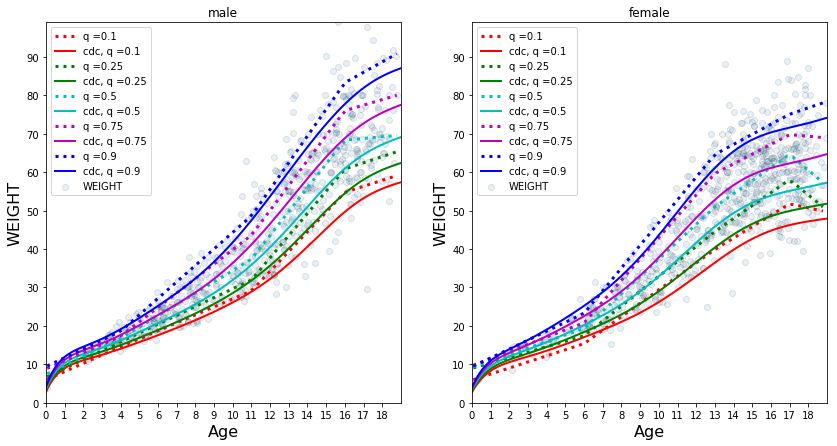

In [48]:
# Plot the results
print('Population comparison to cdc data on ' + response + ' using quantile regression')
plot_bs_qr_wcdc([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           cdc_df = cdc_df,
           response=response)

In [49]:
# Import cdc data
# 2 to 20years
infile  = '/tf/smipipeline/growth_curves/data/csv/statage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]
# infants to 3 years
infile2  = '/tf/smipipeline/growth_curves/data/csv/lenageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='HEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Population comparison to cdc data on HEIGHT using quantile regression


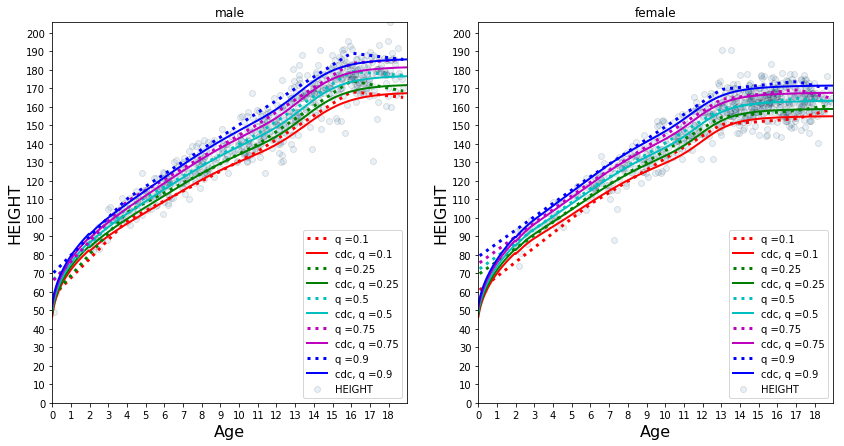

In [50]:
# Plot the results
if cdc_df is not None:
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    plot_bs_qr_wcdc([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               degrees=[degrees_m,degrees_f],
               cdc_df = cdc_df,
               response=response)

In [51]:
# Import cdc data
# 2 to 20years
infile  = '/tf/smipipeline/growth_curves/data/csv/bmiage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

response='BMI_CALC'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Population comparison to cdc data on BMI_CALC using quantile regression


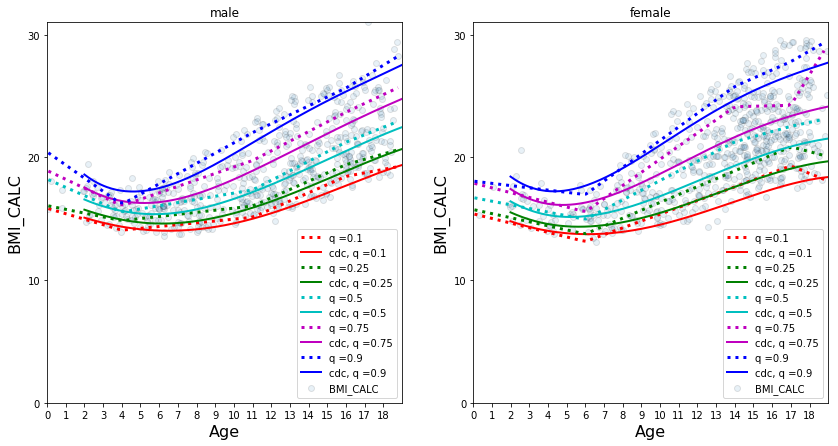

In [52]:
# Plot the results
if cdc_df is not None:
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    plot_bs_qr_wcdc([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               degrees=[degrees_m,degrees_f],
               cdc_df = cdc_df,
               response=response)

In [53]:
response='area_cm2'

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)
Number of outliers > 0.90:  68
Number of outliers < 0.10:  69
Total outliers:  137 Total points:  666
Number of outliers > 0.90:  71
Number of outliers < 0.10:  72
Total outliers:  143 Total points:  695


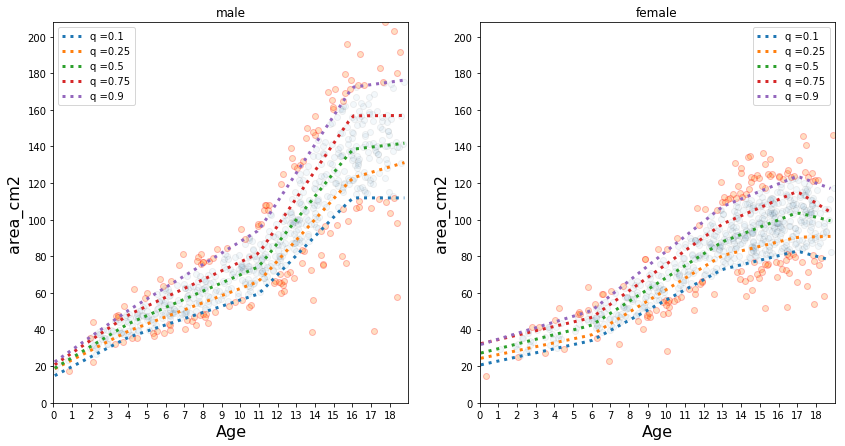

In [54]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)')
plot_bs_qr([df_m,df_f],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response)

## Investigate Outliers

In [55]:
def get_outliers(dfs,
           mlist,
           knots,
           degrees,
          predictor,
          response):
    df_out_m = pd.DataFrame()
    df_out_f = pd.DataFrame()
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]    
        # Plot outliers in red
        x_data = df[predictor].values
        tr_x_data = get_transformed_x(x_data,knots[n],degrees[n])
        y_data = df[response].values
        pat_ids = df['ID'].values
        _,outliers_above = find_points_above(models[-1],tr_x_data,y_data)
        _,outliers_below = find_points_below(models[0],tr_x_data,y_data)
        print('Number of outliers > 0.90: ', sum(outliers_above))
        print('Number of outliers < 0.10: ', sum(outliers_below))
        outliers = outliers_above | outliers_below
        print('Total outliers: ', sum(outliers), 'Total points: ', len(outliers))
        #normals = ~ outliers
        pat_ids_above = pat_ids[outliers_above]
        pat_ids_below = pat_ids[outliers_below]
        df_outliers_above = df[df['ID'].isin(pat_ids_above)]
        df_outliers_below = df[df['ID'].isin(pat_ids_below)]
        df_outliers_above.loc[:,'outlier'] = '>0.90'
        df_outliers_below.loc[:,'outlier'] = '<0.10'
        if n == 0:
            df_out_m = df_outliers_above.append(df_outliers_below, ignore_index=True)
        else:
            df_out_f = df_outliers_above.append(df_outliers_below, ignore_index=True)
        
    return df_out_m,df_out_f

def get_normals(dfs,
           mlist,
           knots,
           degrees,
          predictor,
          response):
    df_out_m = pd.DataFrame()
    df_out_f = pd.DataFrame()
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]    
        # Plot outliers in red
        x_data = df[predictor].values
        tr_x_data = get_transformed_x(x_data,knots[n],degrees[n])
        y_data = df[response].values
        pat_ids = df['ID'].values
        _,outliers_above = find_points_above(models[-1],tr_x_data,y_data)
        _,outliers_below = find_points_below(models[0],tr_x_data,y_data)
        print('Number of outliers > 0.90: ', sum(outliers_above))
        print('Number of outliers < 0.10: ', sum(outliers_below))
        outliers = outliers_above | outliers_below
        print('Total outliers: ', sum(outliers), 'Total points: ', len(outliers))
        normals = ~ outliers
        pat_ids_normals = pat_ids[normals]
        
        df_normals = df[df['ID'].isin(pat_ids_normals)]
        if n == 0:
            df_out_m =df_normals
        else:
            df_out_f = df_normals
        
    return df_out_m,df_out_f

In [56]:
df_out_m, df_out_f = get_outliers([df_m,df_f],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
            predictor = 'Age',
           response=response)

df_out_m = df_out_m.sort_values(by=['area_cm2']).reset_index(drop=True)
df_out_f = df_out_f.sort_values(by=['area_cm2']).reset_index(drop=True)

Number of outliers > 0.90:  68
Number of outliers < 0.10:  69
Total outliers:  137 Total points:  666


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Number of outliers > 0.90:  71
Number of outliers < 0.10:  72
Total outliers:  143 Total points:  695


In [57]:
df_norm_m, df_norm_f = get_normals([df_m,df_f],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
            predictor = 'Age',

                                   response=response)

Number of outliers > 0.90:  68
Number of outliers < 0.10:  69
Total outliers:  137 Total points:  666
Number of outliers > 0.90:  71
Number of outliers < 0.10:  72
Total outliers:  143 Total points:  695


In [58]:
from shutil import copyfile
def copy_patlist_files(df,indir,outdir,ext='.tif'):
    os.makedirs(outdir,exist_ok=True)
    infiles = [f for f in os.listdir(indir) if f.endswith(ext)]
    
    #print(infiles[:5])
    for i,row in df.iterrows():
        matching = [s for s in infiles if row['ID'] in s]
        for match in matching:
            infile = os.path.join(indir,match)
            outfile = os.path.join(outdir,match)
            copyfile(infile,outfile)

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
            
def copy_patlist_axialdcms(df,indir,outdir):
    os.makedirs(outdir,exist_ok=True)
    for i,row in df.iterrows():
        sub_in = os.path.join(indir,row['ID'])
        sub_out = os.path.join(outdir,row['ID'])
        #print('src: ',sub_in)
        #print('dest: ',sub_out)
        try:
            copytree(sub_in,sub_out)
        except:
            print('Folder exists for ', row['ID'])

In [59]:
indir = '/tf/output/cv_poorl3/ms'
outdir = '/tf/output/cv_poorl3/outliers_tifs_iteration2'

df_outliers = df_out_m.append(df_out_f)
copy_patlist_files(df_outliers,indir,outdir)
print("Outlier Images copied to outdir")

Outlier Images copied to outdir


In [60]:
len(df_outliers)

280

In [61]:
display(df_sma_manuals)

,subject_id,area_mm2,% auto mask pixels,% manual mask pixels,area_mm2_Elan,sagittal_series,axial_series
1350,Z1302641,1838.926514,NaN,NaN,4903.0,recon from: Z1302641-SE-2-2MM_ID_4,Z1302641-SE-2-2MM_ID_4
1351,Z489517,2323.608716,NaN,NaN,11150.0,recon from: Z489517-SE-9-Ax-MIP_Lung_Ax-MIP_8.000,Z489517-SE-9-Ax-MIP_Lung_Ax-MIP_8.000
1358,Z1332420,5684.375000,NaN,NaN,6792.0,recon from: Z1332420-SE-8-Ax-MIP_Lung_Ax-MIP_8...,Z1332420-SE-8-Ax-MIP_Lung_Ax-MIP_8.000
1360,Z357478,6321.689712,NaN,NaN,15397.0,recon from: Z357478-SE-8-Ax-MIP_Lung_Ax-MIP_8.000,Z357478-SE-8-Ax-MIP_Lung_Ax-MIP_8.000
1361,Z486791,3108.333115,NaN,NaN,5903.0,recon from: Z486791-SE-5-Venous_Phase_5.0_B31f,Z486791-SE-5-Venous_Phase_5.0_B31f


In [114]:
# Manual Poor L3 Inspection list:
poor_l3 = ['Z1762020',
           'Z1996094',
           'Z717870',
           'Z705523',
           'Z362374',
           'Z890238',
           'Z1722108',
           'Z1256768',
           'Z1119985',
           'Z418856',
           'Z1450371',
           'Z678707',
           'Z670302',
           'Z1302641',
           'Z723781',
           'Z489517',
           'Z1195730',
           'Z1286046',
           'Z320930',
           'Z1263347',
           'Z1000800',
           'Z1274627',
           'Z485332',
           'Z1222041',
           'Z5745',
           'Z876503',
           'Z1029886',
           'Z1262030',
           'Z832424',
           'Z1436778',
           'Z441830',
           'Z1041413',
           'Z567376',
           'Z1332420',
           'Z687529',
           'Z1221549',
           'Z1256084',
           'Z511402',
           'Z357478',
           'Z1211258',
           'Z486791',
           'Z936171',
           'Z1056292',
           'Z837620',
           'Z627309']

In [118]:
print('poor l3s: ', len(poor_l3))
df_poorl3 = df_outliers[df_outliers['ID'].isin(poor_l3)].reset_index(drop=True)
print('Length of all poor l3s: ', len(df_poorl3['ID']))

missing = [p for p in poor_l3 if p not in df_poorl3['ID'].values]
print(missing)

poor l3s:  45
Length of all poor l3s:  45
[]


In [125]:
indir = '/tf/data'
outdir = '/tf/output/outliers_dcms'
copy_patlist_axialdcms(df_poorl3,indir,outdir)
print('Moved all DICOMS to outdir')

Folder exists for  Z1996094
Moved all DICOMS to outdir


In [126]:
df_poorl3_id = df_poorl3[['ID']]
df_poorl3_id.to_csv(os.path.join(outdir,'poorl3.csv'))

In [54]:
print("[\"")
print(*df_out_m.loc[182:,'ID'].values,sep='", "')
print("\"]")

#display(df_out_f[['ID','area_cm2','axials']].head(11))

["
Z422122", "Z1109476", "Z654902", "Z659670", "Z933945", "Z941630", "Z917389", "Z5745", "Z693521", "Z1432145", "Z944973", "Z377539", "Z432563", "Z445300", "Z1047725", "Z423050", "Z1108612", "Z934752", "Z542803", "Z1462171", "Z878058", "Z372476", "Z445313", "Z540428", "Z1003148", "Z1015067", "Z620944", "Z949241", "Z842715", "Z877689", "Z569118", "Z842219", "Z829322", "Z838508", "Z983086", "Z918026", "Z735782", "Z578345", "Z1272833", "Z882601", "Z943778", "Z934271", "Z873213", "Z896236", "Z666165", "Z424181", "Z1258216", "Z936019", "Z937153", "Z891398", "Z374705
"]


In [57]:
display(df_out_f[['ID','area_cm2','axials']].tail(50))

,ID,area_cm2,axials
198,Z1108064,122.546875,Z1108064-SE-7-Std_Pediatric_5.0_CE
199,Z453391,122.565541,Z453391-SE-4-Axial_Body_5.0
200,Z850232,122.806621,Z850232-SE-3-Body_5.0
201,Z535688,122.831697,Z535688-SE-4-Body_Std._Axial_AIDR_-_H_5.0
202,Z937469,123.024187,Z937469-SE-7-Std_Pediatric_5.0_CE
203,Z819717,123.060466,Z819717-SE-4-Axial_Std_5.0_CE
204,Z1207909,123.187500,Z1207909-SE-2-Standard_Axial
205,Z828131,123.203885,Z828131-SE-4-Standard
206,Z861912,123.292330,Z861912-SE-1003-Body_Clarity
207,Z1082737,123.828125,Z1082737-SE-5-Axial_Body_5.0


In [ ]:
display(df_norm_f.head(10))

In [ ]:
import cv2
def show_figures(figlist,titlist):
    plt.figure(figsize = (15,8))
    for n in range(len(figlist)):
        im = cv2.imread(figlist[n])
        im_resized = cv2.resize(im, (1024, 1024), interpolation=cv2.INTER_LINEAR)
        ax = plt.subplot(1,2,n+1)
        ax.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
        ax.set_title(titlist[n])
        ax.axis('off')

In [ ]:
print("Psoas Muscle Results from Metzger.et.al")
f1  = '/tf/smipipeline/growth_curves/data/PMA Metzger Male.png'
f2  = '/tf/smipipeline/growth_curves/data/PMA Metzger Female.png'

show_figures([f1,f2],['Male','Female'])

In [ ]:
print("Psoas Muscle Results from Lurz.et.al")
f1  = '/tf/smipipeline/growth_curves/data/Lurz PMA male.png'
f2  = '/tf/smipipeline/growth_curves/data/Lurtz PMA female.png'

show_figures([f1,f2],['Male','Female'])

In [ ]:
response='smi'


df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

In [ ]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data]')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response)

In [ ]:
print("Psoas Muscle Index Results from Metzger.et.al")
f1  = '/tf/smipipeline/growth_curves/data/Metzger et al pmi male.png'
f2  = '/tf/smipipeline/growth_curves/data/Metzger et al pmi female.png'

show_figures([f1,f2],['Male','Female'])

In [ ]:
response='area_cm2'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

In [ ]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area [CCHMC data] vs Weight')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [ ]:
response='smi'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

In [ ]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs Weight')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [ ]:
response='area_cm2'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

In [ ]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area [CCHMC data] vs HEIGHT')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [ ]:
response='smi'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

In [ ]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs HEIGHT')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [ ]:
response='area_cm2'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

In [ ]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area [CCHMC data] vs BMI percentile')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)

In [ ]:
response='smi'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m,degrees_m = spline_model_optimizer(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f,degrees_f = spline_model_optimizer(df_f_nonull, response,predictor_var=predictor)



# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.10,0.25,0.50,0.75,0.90])
fit_models_f = fit_bs_models(model_f,qlist=[0.10,0.25,0.50,0.75,0.90])

In [ ]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI percentile')
plot_bs_qr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           degrees=[degrees_m,degrees_f],
           response=response,predictor=predictor)